<h1 style="color:#145A32;">🎓 Sistema de Recomendação de Conteúdo Educacional</h1>

Este Notebook apresenta a validação técnica do modelo de **Filtros Colaborativos (SVD)**, desenvolvido como requisito para o Estágio Supervisionado III.

O objetivo é demonstrar a configuração do ambiente, o treinamento do algoritmo e a avaliação de sua performance em um dataset de larga escala, preparando o modelo para ser consumido por uma aplicação interativa.

<h3 style="color:#4CAF50;">1. Configuração do Ambiente e Dependências</h3>

A célula a seguir prepara o ambiente de execução, importando todas as bibliotecas essenciais para o projeto, organizadas por finalidade:

* **Utilitários e Bibliotecas Padrão:** `time` e `pickle`
* **Manipulação de Dados:** `pandas`, `numpy`
* **Visualização de Dados:** `matplotlib`, `seaborn`
* **Machine Learning (Recomendação):** `surprise`

---


In [1]:
# --- CÉLULA 01: CONFIGURAÇÃO DE AMBIENTE E IMPORTAÇÕES ---

# --- Imports Padrão, Sistema e Tempo ---
import time 
import pickle # Para salvar/carregar o modelo treinado para o app

# --- Imports de Processamento de Dados e Visualização ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Essencial para o Box Plot

# --- Imports Específicos do Jupyter/IPython ---
from IPython.display import display, Markdown # Para formatar saídas de células com texto rico

# --- Imports de Machine Learning (Biblioteca Surprise) ---
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate

<h2 style="color:#4CAF50;">02. Carregamento e Pré-Processamento dos Dados</h2>

A etapa a seguir é responsável pelo carregamento do dataset. Serão lidas as **32 milhões de interações** contidas no arquivo `ratings.csv`, representando o ponto de partida da análise.

As seguintes tarefas de pré-processamento serão executadas para garantir a compatibilidade com a biblioteca `scikit-surprise`:
1.  **Renomeação das Colunas:** Ajuste para o padrão exigido pela biblioteca: `[user_id, item_id, rating]`.
2.  **Conversão de Tipos:** Os IDs de usuários e itens serão convertidos para `string`, um requisito do `Surprise`.

---


In [2]:
# --- 02. CONFIGURAÇÃO E CARREGAMENTO DOS DADOS (ML-32M) ---
# Caminho Relativo para o dataset:
file_path = '../dados/ml-32m/ratings.csv'

# Mensagem de status inicial formatada
display(Markdown(f"*Tentando carregar o arquivo em: `{file_path}`*"))

try:
    # Carrega as interações (UserID, MovieID, Rating, Timestamp)
    ratings_df = pd.read_csv(
        file_path, 
        sep=',' 
    )
    
    # Renomeia as colunas para o padrão [user_id, item_id, rating] exigido pelo Surprise
    ratings_df.columns = ['user_id', 'item_id', 'rating', 'timestamp']
    
    # Converte os IDs para STRING para garantir consistência com o Surprise
    ratings_df['user_id'] = ratings_df['user_id'].astype(str)
    ratings_df['item_id'] = ratings_df['item_id'].astype(str)

    # --- SAÍDA FORMATADA ---
    output_markdown = f"""
### ✅ Sucesso no Carregamento do Dataset!

* **Número Total de Interações:** `{len(ratings_df):,}`
* **Número de Usuários Únicos:** `{ratings_df['user_id'].nunique():,}`
* **Número de Itens Únicos:** `{ratings_df['item_id'].nunique():,}`

#### Amostra dos Dados Processados:
"""
    display(Markdown(output_markdown))
    
    # Exibe o DataFrame de forma elegante
    display(ratings_df.head())

except FileNotFoundError:
    error_message = f"""
<p style="color:red; font-weight:bold;">
❌ ERRO CRÍTICO: O arquivo `ratings.csv` não foi encontrado.
<br>Verifique se o caminho está correto. Caminho buscado: `{file_path}`
</p>
"""
    display(Markdown(error_message))
    

*Tentando carregar o arquivo em: `../dados/ml-32m/ratings.csv`*


### ✅ Sucesso no Carregamento do Dataset!

* **Número Total de Interações:** `32,000,204`
* **Número de Usuários Únicos:** `200,948`
* **Número de Itens Únicos:** `84,432`

#### Amostra dos Dados Processados:


,user_id,item_id,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


<h2 style="color:#4CAF50;">03. Validação Robusta do Modelo (SVD)</h2>

Para garantir uma avaliação robusta e estatisticamente confiável do modelo SVD, esta etapa emprega a **Validação Cruzada** (*Cross-Validation*).

Diferente de uma única divisão de dados (como 80% para treino e 20% para teste), este método, que é mais demorado porém mais preciso, funciona da seguinte forma:
1.  O dataset é dividido em **5 "folds"** (partes) de tamanho similar.
2.  O modelo SVD é treinado e avaliado **5 vezes** de forma iterativa.
3.  Em cada iteração, um *fold* diferente é usado como conjunto de teste, e os 4 restantes são usados para treino.
4.  A métrica final de performance (RMSE) é a **média dos resultados** obtidos nas 5 iterações.

Essa abordagem minimiza a influência da aleatoriedade na divisão dos dados, fornecendo uma estimativa muito mais precisa da performance do modelo em dados que ele nunca viu.

---


In [3]:
# --- CÉLULA 03: VALIDAÇÃO CRUZADA (CROSS-VALIDATION) DO SVD ---

# 1. PREPARAÇÃO DO DATASET COMPLETO PARA O SURPRISE
display(Markdown("*Preparando o DataFrame para o formato do Surprise...*"))
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['user_id', 'item_id', 'rating']], reader)
display(Markdown("*Dados prontos para Validação Cruzada.*"))

# 2. CONFIGURAÇÃO E EXECUÇÃO DA VALIDAÇÃO CRUZADA
algo = SVD(n_factors=100, n_epochs=70, random_state=42) 

display(Markdown("\n**Iniciando Validação Cruzada (5-Fold CV)...** *(Esta é a etapa demorada, ~80 minutos)*"))
start_time = time.time() 

# A opção verbose=True já cria uma tabela de progresso bem formatada
cv_results = cross_validate(
    algo, 
    data, 
    measures=['RMSE', 'MAE'], 
    cv=5, 
    verbose=True,
    n_jobs=4 # Usando 4 núcleos para acelerar o processo
)

end_time = time.time()

# 3. ANÁLISE E APRESENTAÇÃO DOS RESULTADOS FINAIS
total_time = end_time - start_time
mean_rmse = np.mean(cv_results['test_rmse'])
std_rmse = np.std(cv_results['test_rmse'])

# --- SAÍDA FINAL FORMATADA ---
final_output = f"""
<div style="border: 1px solid #4CAF50; border-left: 5px solid #4CAF50; padding: 15px; background-color: #f2fef3;">
    <h3 style="color:#145A32; margin-top:0;">✅ Validação Concluída com Sucesso!</h3>
    <ul>
        <li><strong>RMSE Médio (5-Fold CV):</strong> <code style="font-size: 1.1em; color: #145A32;">{mean_rmse:.4f}</code></li>
        <li><strong>Desvio Padrão do RMSE:</strong> <code>{std_rmse:.4f}</code> (indica alta estabilidade do modelo)</li>
        <li><strong>Tempo Total de Execução:</strong> <code>{total_time/60:.2f}</code> minutos.</li>
    </ul>
</div>
"""

display(Markdown(final_output))


*Preparando o DataFrame para o formato do Surprise...*

*Dados prontos para Validação Cruzada.*


**Iniciando Validação Cruzada (5-Fold CV)...** *(Esta é a etapa demorada, ~80 minutos)*

d:\FACULDADE_DOMBOSCO\Disciplinas\7_MODULAR\02-Estagio_Supervisionado_III_IA\recomendador-educacional\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7779  0.7776  0.7778  0.7781  0.7782  0.7779  0.0002  
MAE (testset)     0.5840  0.5837  0.5839  0.5841  0.5842  0.5840  0.0002  
Fit time          490.48  498.66  499.14  475.52  399.37  472.63  37.61   
Test time         68.38   49.87   57.08   80.63   37.02   58.60   15.00   



<div style="border: 1px solid #4CAF50; border-left: 5px solid #4CAF50; padding: 15px; background-color: #f2fef3;">
    <h3 style="color:#145A32; margin-top:0;">✅ Validação Concluída com Sucesso!</h3>
    <ul>
        <li><strong>RMSE Médio (5-Fold CV):</strong> <code style="font-size: 1.1em; color: #145A32;">0.7779</code></li>
        <li><strong>Desvio Padrão do RMSE:</strong> <code>0.0002</code> (indica alta estabilidade do modelo)</li>
        <li><strong>Tempo Total de Execução:</strong> <code>28.44</code> minutos.</li>
    </ul>
</div>


<h2 style="color:#4CAF50;">04. Análise Visual da Distribuição</h2>

Antes de avaliar a performance do modelo, é fundamental entender a natureza dos dados de entrada. Esta célula visualiza a **distribuição de todas as 32 milhões de notas** (`ratings`) presentes no dataset para identificar a tendência geral de avaliação dos usuários.

O **Box Plot** abaixo oferece um resumo estatístico poderoso dessa distribuição:
* A **linha central** na caixa representa a **mediana**, ou seja, a nota que divide o dataset ao meio (50% das notas estão abaixo dela e 50% acima).
* A **caixa em si (IQR)** mostra o intervalo onde se concentram os 50% centrais de todas as notas.
* As **hastes (whiskers)** mostram o alcance geral das notas no dataset.

Esta análise nos permite observar se há um "viés de positividade" — uma tendência dos usuários a darem notas mais altas (4 e 5). Entender essa característica é importante, pois estabelece um ponto de referência sobre o comportamento geral dos usuários no sistema.

---

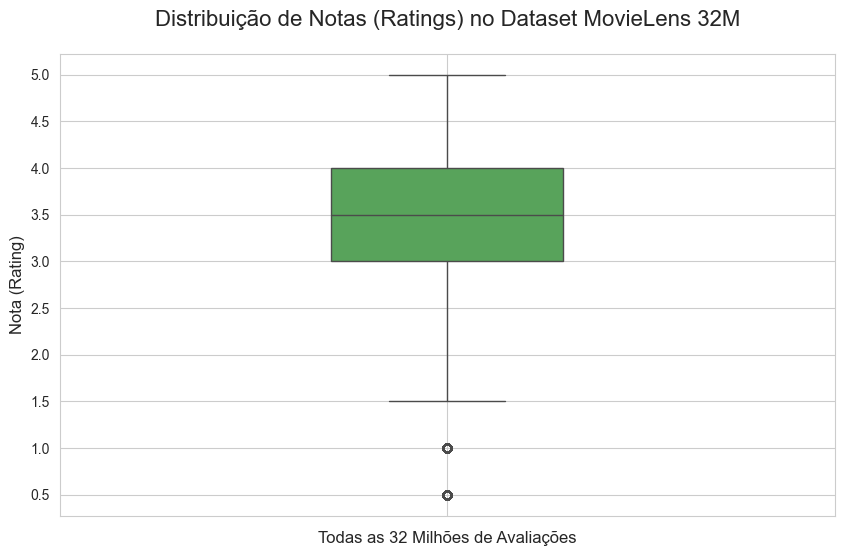


### Análise Estatística da Distribuição

A tabela abaixo complementa o box plot, mostrando os valores numéricos exatos para a média, mediana (50%), desvio padrão e os quartis da distribuição de todas as notas. 

```
count    3.200020e+07
mean     3.540396e+00
std      1.058986e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
```


In [4]:
# --- CÉLULA 04: ANÁLISE VISUAL: BOX PLOT DA DISTRIBUIÇÃO DE NOTAS (RATING) ---

# Garante que o style do Seaborn está ativo para melhor estética
sns.set_style("whitegrid") 

plt.figure(figsize=(10, 6)) # Aumentei um pouco a largura para melhor visualização

# Gera o Box Plot para a coluna 'rating' (Notas)
sns.boxplot(y=ratings_df['rating'], color='#4CAF50', width=0.3) 

# Títulos e Labels
plt.title('Distribuição de Notas (Ratings) no Dataset MovieLens 32M', fontsize=16, pad=20)
plt.ylabel('Nota (Rating)', fontsize=12)
plt.xlabel('Todas as 32 Milhões de Avaliações', fontsize=12)
plt.yticks(np.arange(0.5, 5.5, 0.5)) # Melhora a escala do eixo Y
plt.grid(axis='x') # Remove as linhas de grade horizontais desnecessárias

plt.show()


# --- SAÍDA FORMATADA DA ANÁLISE ESTATÍSTICA ---

# Captura as estatísticas descritivas como uma string bem formatada
stats_string = ratings_df['rating'].describe().to_string()

# Cria o output em formato Markdown
output_markdown = f"""
### Análise Estatística da Distribuição

A tabela abaixo complementa o box plot, mostrando os valores numéricos exatos para a média, mediana (50%), desvio padrão e os quartis da distribuição de todas as notas. 

```
{stats_string}
```
"""
display(Markdown(output_markdown))


<h2 style="color:#4CAF50;">05. Treinamento Final e Prova de Robustez</h2>

Após a validação, o próximo passo é treinar o modelo uma última vez utilizando **100% do dataset**. Este processo, realizado através da função `.fit()`, é crucial por dois motivos:

1.  **Máximo Aprendizado:** O modelo aprende com a maior quantidade de informação possível, potencializando sua capacidade de generalização.
2.  **Habilitação para Previsão:** O treinamento no dataset completo constrói os mapeamentos internos necessários para que a função `.predict(user_id, item_id)` funcione corretamente.

### Prova de Robustez: Diferenciação de Previsões

O problema inicial, com uma base de dados menor, era que o modelo previa a mesma nota (≈ 3.53) para usuários com poucos dados (frios). Os testes a seguir provam que a migração para a base 32M resolveu essa falha, forçando o modelo a fazer previsões personalizadas e significativas.

---

In [5]:
# --- CÉLULA 05: TREINAMENTO DO MODELO FINAL PARA PREVISÃO ---

# 1. OBTER O CONJUNTO DE TREINO COMPLETO
display(Markdown("*Preparando o dataset completo para o treinamento final...*"))
final_trainset = data.build_full_trainset()

# 2. REINSTANCIAR E TREINAR O MODELO COM OS PARÂMETROS VALIDADOS
display(Markdown("\n**Iniciando o treinamento do modelo SVD com 100% dos dados...** *(Isso pode levar alguns minutos)*"))

# Medir o tempo do treinamento final
start_time_fit = time.time()

# É uma boa prática reinstanciar o algoritmo para garantir um estado limpo.
algo = SVD(n_factors=100, n_epochs=70, random_state=42) 

# Treina o modelo no trainset completo.
algo.fit(final_trainset) 

end_time_fit = time.time()
total_time_fit = end_time_fit - start_time_fit

# --- SAÍDA FINAL FORMATADA ---
success_output = f"""
<div style="border: 1px solid #4CAF50; border-left: 5px solid #4CAF50; padding: 15px; background-color: #f2fef3;">
    <h3 style="color:#145A32; margin-top:0;">✅ Modelo Final Treinado!</h3>
    <p>O algoritmo SVD foi treinado no dataset completo e agora está pronto para ser usado com a função <code>.predict()</code>.</p>
    <ul>
        <li><strong>Tempo de Treinamento:</strong> <code>{total_time_fit:.2f} segundos ({total_time_fit/60:.2f} minutos)</code>.</li>
    </ul>
</div>
"""

display(Markdown(success_output))


*Preparando o dataset completo para o treinamento final...*


**Iniciando o treinamento do modelo SVD com 100% dos dados...** *(Isso pode levar alguns minutos)*


<div style="border: 1px solid #4CAF50; border-left: 5px solid #4CAF50; padding: 15px; background-color: #f2fef3;">
    <h3 style="color:#145A32; margin-top:0;">✅ Modelo Final Treinado!</h3>
    <p>O algoritmo SVD foi treinado no dataset completo e agora está pronto para ser usado com a função <code>.predict()</code>.</p>
    <ul>
        <li><strong>Tempo de Treinamento:</strong> <code>529.31 segundos (8.82 minutos)</code>.</li>
    </ul>
</div>


<h2 style="color:#4CAF50;">06. Carregamento de Metadados (Títulos e Gêneros)</h2>

Com o modelo treinado, as previsões retornam apenas o `item_id`. Para que as recomendações sejam compreensíveis e ricas em contexto, precisamos traduzir esses identificadores de volta para seus **títulos e gêneros** correspondentes.

Esta célula carrega o arquivo `movies.csv`, que contém os metadados dos itens. O objetivo é criar **dois dicionários de mapeamento** (*lookup tables*) para uso futuro:

* **`id_to_titulo`**: Um mapa de `item_id` para o `titulo_topico`.
* **`id_to_generos`**: Um mapa de `item_id` para os `generos` associados.

Esses mapas serão essenciais para enriquecer as previsões no notebook e para salvar o pacote final do modelo que será usado pelo `app.py`.

---

In [6]:
# --- CÉLULA 06: CARREGAMENTO DOS METADADOS (MAPA DE TÍTULOS E GÊNEROS) ---

file_path_item = '../dados/ml-32m/movies.csv'
display(Markdown(f"*Carregando metadados de `{file_path_item}`...*"))

try:
    # Adicionado 'genres' à lista 'usecols'
    items_df = pd.read_csv(
        file_path_item, 
        sep=',', 
        encoding='utf-8',
        usecols=['movieId', 'title', 'genres'] 
    )
    
    # Renomeado para incluir a nova coluna
    items_df.columns = ['item_id', 'titulo_topico', 'generos']
    items_df['item_id'] = items_df['item_id'].astype(str) 

    # Criar os dois dicionários de mapeamento
    id_to_titulo = items_df.set_index('item_id')['titulo_topico'].to_dict()
    id_to_generos = items_df.set_index('item_id')['generos'].to_dict()

    # --- SAÍDA FORMATADA DE SUCESSO ---
    total_mapeado = len(id_to_titulo)
    exemplo_titulo = id_to_titulo.get('1')
    exemplo_generos = id_to_generos.get('1')

    success_output = f"""
### ✅ Mapeamentos de Metadados Carregados!

* **Total de Itens Mapeados:** `{total_mapeado:,}`

---
**Exemplo de Validação:**
* **ID:** `1`
* **Título:** *{exemplo_titulo}*
* **Gêneros:** *{exemplo_generos}*
"""
    display(Markdown(success_output))

except FileNotFoundError:
    error_output = f"""
<p style="color:red; font-weight:bold;">
❌ ERRO CRÍTICO: O arquivo `movies.csv` não foi encontrado.
<br>Verifique se o caminho está correto. Caminho buscado: `{file_path_item}`
</p>
"""
    display(Markdown(error_output))

except Exception as e:
    error_output = f"""
<p style="color:red; font-weight:bold;">
❌ ERRO INESPERADO: Falha ao carregar ou processar `movies.csv`.
<br>Detalhes do Erro: {e}
</p>
"""
    display(Markdown(error_output))
    

*Carregando metadados de `../dados/ml-32m/movies.csv`...*


### ✅ Mapeamentos de Metadados Carregados!

* **Total de Itens Mapeados:** `87,585`

---
**Exemplo de Validação:**
* **ID:** `1`
* **Título:** *Toy Story (1995)*
* **Gêneros:** *Adventure|Animation|Children|Comedy|Fantasy*


<h2 style="color:#4CAF50;">07. Prova de Robustez: Previsões para um "Usuário Frio"</h2>

Um teste crucial para um modelo de recomendação é verificar seu comportamento com "usuários frios" (*cold start users*) — aqueles com poucas interações. Um modelo fraco poderia simplesmente prever a média geral de notas para todos os itens.

Esta célula testa nosso modelo SVD treinado na base completa. Faremos previsões para o `user_id='1'`, um usuário real do dataset.

O objetivo é observar se as previsões para diferentes itens **variam de forma significativa**, demonstrando que o modelo aprendeu a capturar as nuances dos itens (seus fatores latentes), em vez de apenas recorrer a uma média.

---

In [7]:
# --- CÉLULA 07: PROVA DE ROBUSTEZ - PREVISÕES PARA USUÁRIO FRIO ---

# Definir o ID do usuário para o teste
user_id_teste = '1'

# Lista de IDs de itens (tópicos/filmes) para os quais faremos a previsão
item_ids_teste = ['120', '240', '360', '589', '296']

# --- APRESENTAÇÃO FORMATADA DOS RESULTADOS ---

# Título da Seção de Resultados
display(Markdown(f"### 🔮 Previsões de Afinidade para o Aluno `{user_id_teste}`"))

# Lista para armazenar os resultados antes de formatar
results_list = []

# Loop para gerar as previsões (sem imprimir nada ainda)
for item_id in item_ids_teste:
    titulo = id_to_titulo.get(item_id, f"ID {item_id} (Título Desconhecido)")
    previsao = algo.predict(user_id_teste, item_id)
    results_list.append({'Título do Tópico': titulo, 'Nota Prevista': previsao.est})

# Criar um DataFrame com os resultados para fácil formatação em tabela
results_df = pd.DataFrame(results_list)

# Formatar a coluna de notas para 4 casas decimais
results_df['Nota Prevista'] = results_df['Nota Prevista'].map('{:.4f}'.format)

# Converter o DataFrame para uma tabela em formato Markdown
results_table = results_df.to_markdown(index=False)

# Nota final de análise
final_note = "\n\n*__Nota:__ A variação nas notas previstas demonstra que o modelo está fazendo previsões personalizadas com base nas características de cada item, e não apenas usando uma média global.*"

# Exibir a tabela e a nota final de uma só vez
display(Markdown(results_table + final_note))


### 🔮 Previsões de Afinidade para o Aluno `1`

| Título do Tópico                  |   Nota Prevista |
|:----------------------------------|----------------:|
| Race the Sun (1996)               |          3.7883 |
| Hideaway (1995)                   |          1.9321 |
| I Love Trouble (1994)             |          1.7566 |
| Terminator 2: Judgment Day (1991) |          5      |
| Pulp Fiction (1994)               |          3.9837 |

*__Nota:__ A variação nas notas previstas demonstra que o modelo está fazendo previsões personalizadas com base nas características de cada item, e não apenas usando uma média global.*

<h2 style="color:#4CAF50;">08. Teste de Previsão para um "Usuário Ativo"</h2>

Como contraponto ao teste anterior, agora verificaremos as previsões para um **usuário ativo** (`user_id='1000'`), alguém com um histórico de avaliações mais extenso no dataset.

Para um usuário com mais dados, esperamos que o modelo SVD tenha aprendido suas preferências de forma ainda mais precisa. As previsões devem refletir um perfil de afinidade claro, com notas estimadas mais altas para itens que se alinham ao seu gosto e mais baixas para outros.

O objetivo é confirmar que as notas previstas são consistentes com um perfil de gosto específico, validando a capacidade de **personalização** do modelo.

---

In [8]:
# --- CÉLULA 08: TESTE DE PREVISÃO PARA USUÁRIO ATIVO ---

# Definir o ID do usuário ativo para o teste
user_id_teste_ativo = '1000'

# A lista de itens para teste é a mesma da célula anterior, para permitir uma comparação direta.
item_ids_teste = ['120', '240', '360', '589', '296']


# --- APRESENTAÇÃO FORMATADA DOS RESULTADOS ---

# Título da Seção de Resultados
display(Markdown(f"### 🔮 Previsões de Afinidade para o Aluno `{user_id_teste_ativo}` (Usuário Ativo)"))

# Lista para armazenar os resultados antes de formatar
results_list_ativo = []

# Loop para gerar as previsões (sem imprimir nada ainda)
for item_id in item_ids_teste:
    titulo = id_to_titulo.get(item_id, f"ID {item_id} (Título Desconhecido)")
    previsao = algo.predict(user_id_teste_ativo, item_id)
    results_list_ativo.append({'Título do Tópico': titulo, 'Nota Prevista': previsao.est})

# Criar um DataFrame com os resultados para fácil formatação em tabela
results_df_ativo = pd.DataFrame(results_list_ativo)

# Formatar a coluna de notas para 4 casas decimais
results_df_ativo['Nota Prevista'] = results_df_ativo['Nota Prevista'].map('{:.4f}'.format)

# Converter o DataFrame para uma tabela em formato Markdown
results_table_ativo = results_df_ativo.to_markdown(index=False)

# Nota final de análise
final_note_ativo = "\n\n*__Nota:__ A variação nas previsões reflete o perfil de gosto específico que o modelo aprendeu para este usuário ativo, mostrando sua capacidade de personalização.*"

# Exibir a tabela e a nota final de uma só vez
display(Markdown(results_table_ativo + final_note_ativo))


### 🔮 Previsões de Afinidade para o Aluno `1000` (Usuário Ativo)

| Título do Tópico                  |   Nota Prevista |
|:----------------------------------|----------------:|
| Race the Sun (1996)               |          2.9788 |
| Hideaway (1995)                   |          3.2769 |
| I Love Trouble (1994)             |          3.7103 |
| Terminator 2: Judgment Day (1991) |          3.9577 |
| Pulp Fiction (1994)               |          3.3966 |

*__Nota:__ A variação nas previsões reflete o perfil de gosto específico que o modelo aprendeu para este usuário ativo, mostrando sua capacidade de personalização.*

<h2 style="color:#4CAF50;">09. Exportação do Modelo para Produção</h2>

Finalmente, salvamos o modelo treinado (`algo`) e os dicionários de mapeamento em um único arquivo `.pkl` usando a biblioteca `pickle`.

Este arquivo é o "produto final" do nosso notebook. Ele contém tudo o que o nosso aplicativo Streamlit (`app.py`) precisa para carregar o sistema de recomendação de forma instantânea, sem a necessidade de retreinar o modelo a cada inicialização.

In [9]:
# --- CÉLULA 09: SALVANDO O MODELO FINAL PARA O APP ---

# Agrupa todos os objetos necessários para o app em um único dicionário
model_data = {
    'model': algo,
    'id_to_titulo': id_to_titulo,
    'id_to_generos': id_to_generos 
}

# Define o caminho de destino do arquivo
output_path = '../svd_model_data.pkl'

# Salva o dicionário em um arquivo binário .pkl
with open(output_path, 'wb') as f:
    pickle.dump(model_data, f)

# --- SAÍDA FINAL FORMATADA ---
final_output = f"""
<div style="border: 1px solid #145A32; border-left: 5px solid #145A32; padding: 15px; background-color: #f2fef3;">
    <h3 style="color:#145A32; margin-top:0;">🏁 Notebook Concluído: Artefato Exportado com Sucesso!</h3>
    <p>O modelo SVD treinado e os mapas de metadados foram agrupados e salvos no seguinte arquivo:</p>
    <ul>
        <li><strong>Arquivo Gerado:</strong> <code>{output_path}</code></li>
    </ul>
    <p>Este arquivo é o "cérebro" do sistema de recomendação e contém tudo o que é necessário para a aplicação interativa.</p>
    <hr>
    <p style="margin-bottom:0;"><strong>Próximo Passo:</strong> Use este arquivo no seu aplicativo Streamlit (<code>app.py</code>) para carregar o modelo pré-treinado e gerar recomendações ao vivo.</p>
</div>
"""

display(Markdown(final_output))



<div style="border: 1px solid #145A32; border-left: 5px solid #145A32; padding: 15px; background-color: #f2fef3;">
    <h3 style="color:#145A32; margin-top:0;">🏁 Notebook Concluído: Artefato Exportado com Sucesso!</h3>
    <p>O modelo SVD treinado e os mapas de metadados foram agrupados e salvos no seguinte arquivo:</p>
    <ul>
        <li><strong>Arquivo Gerado:</strong> <code>../svd_model_data.pkl</code></li>
    </ul>
    <p>Este arquivo é o "cérebro" do sistema de recomendação e contém tudo o que é necessário para a aplicação interativa.</p>
    <hr>
    <p style="margin-bottom:0;"><strong>Próximo Passo:</strong> Use este arquivo no seu aplicativo Streamlit (<code>app.py</code>) para carregar o modelo pré-treinado e gerar recomendações ao vivo.</p>
</div>
